In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4
# from coordinate_space import *
from utility import log_mesh
from mottmassey import mm_potential

plt.style.use('science')

In [2]:
INIT_CONDITIONS = np.array([0, 1])
IVP_R_ENDPTS = np.array([1e-2, 100])

def normalization_r_mesh(r_max):
    return log_mesh(0, r_max, 5000)


def wave_function_solution(v_r, energy, r_endpts=IVP_R_ENDPTS):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], INIT_CONDITIONS[1]], rtol=1e-8, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol


def normalization_constant(v_r, energy, r_max=100):
    r, wr = normalization_r_mesh(r_max)
    u = wave_function_solution(v_r, energy)(r)[0]
    iC2 = np.dot(wr, u**2)
    return 1/np.sqrt(iC2)


def normalized_wave_function(v_r, energy, r_max=100):
    r, wr = normalization_r_mesh(r_max)
    u = wave_function_solution(v_r, energy)(r)[0]
    iC2 = np.dot(wr, u**2)
    return 1/np.sqrt(iC2) * u


def bound_state_tail(energy, interaction, r_0, endpts=IVP_R_ENDPTS):
    sol = wave_function_solution(interaction, energy, r_endpts=endpts)
    return sol(r_0)[0]


def D(energy, interaction, r_0, endpts=IVP_R_ENDPTS):
    sol = wave_function_solution(interaction, energy, r_endpts=[IVP_R_ENDPTS[0], 1.1*r_0])
    u, up = sol(r_0)
    gamma = np.sqrt(2*MU*-energy)
    return gamma*u + up
    
    
def bound_state(interaction, guess, r_0, endpts=IVP_R_ENDPTS):
    result = fsolve(lambda en: D(en, interaction, r_0, endpts=endpts), guess, factor=0.1)
    return result[0]

In [3]:
rgf = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')

In [9]:
spec_mm = np.loadtxt('spectra_Mott_Massey_hp.txt')
gamma_mm = np.sqrt(2*MU*-spec_mm)
r0_mm = -1/gamma_mm * np.log(1e-10)

In [10]:
index = 6
r0 = r0_mm[index]
e2 = bound_state(mm_potential, spec_mm[index], r0, endpts=[5e-5, 1.1*r0])

r0, e2, spec_mm[index]

(96.29087690537531, -0.00012024566750892399, -0.00012025007849439747)

In [11]:
for i in np.linspace(0.01, 0.0005, 10):
    print(
        i, bound_state(mm_potential, spec_mm[index], r0, endpts=[i, 100])
    )

0.01 -0.00012024566750892399
0.008944444444444444 -0.00012024566750892399
0.00788888888888889 -0.00012024566750892399
0.006833333333333334 -0.00012024566750892399
0.005777777777777778 -0.00012024566750892399
0.004722222222222223 -0.00012024566750892399
0.003666666666666667 -0.00012024566750892399
0.002611111111111112 -0.00012024566750892399
0.0015555555555555566 -0.00012024566750892399
0.0005 -0.00012024566750892399


In [12]:
u1 = normalized_wave_function(mm_potential, spec_mm[index], r0)
u2 = normalized_wave_function(mm_potential, e2, r0)

r, wr = normalization_r_mesh(r0)

normalization_constant(mm_potential, e2, r0)

0.4682926616775064

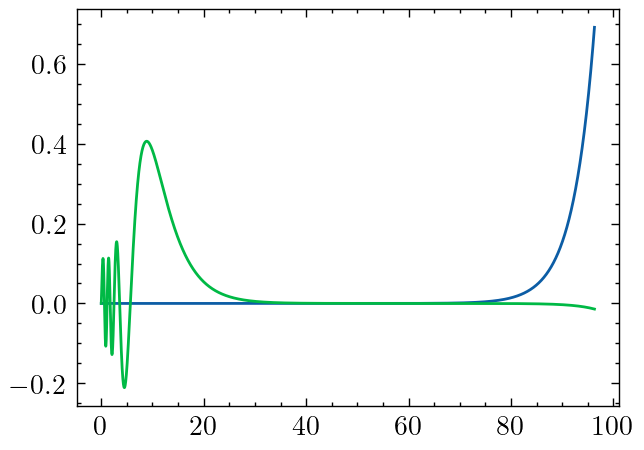

In [13]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(r, u1)
ax.plot(r, u2);

In [15]:
spec_mm_1 = np.array([])

for (en, r0) in zip(spec_mm, r0_mm):
    spec_mm_1 = np.append(spec_mm_1, bound_state(mm_potential, en, r0))

In [16]:
for (x, y) in zip(spec_mm, spec_mm_1):
    print(f'{x:.8f}  {y:.8f}')

-0.06476100  -0.06476102
-0.04422776  -0.04422778
-0.02740752  -0.02740751
-0.01466230  -0.01466227
-0.00611667  -0.00611664
-0.00156344  -0.00156342
-0.00012025  -0.00012025


In [17]:
np.savetxt('spectrum_Mott_Massey_hp_coord.txt', spec_mm_1)

In [19]:
guess = spec_mm_1.copy()
spectra = []

for (R, c0) in rgf:
    pot = lambda r: potential(r, R) + c0*local_LO_counterterm(r, R)
    spec = np.array([bound_state(pot, en, r0) for (en, r0) in zip(guess, r0_mm)])
    wfs = np.array([])
    guess = spec.copy()
    spectra.append(spec)

KeyboardInterrupt: 

In [22]:
n = len(spectra)

In [27]:
np.savetxt('spectra_local_lo_a0_fix_hp_n_14.txt', np.vstack((rgf[:n, 0], np.array(spectra).T)).T)

In [28]:
solutions = []

for ((R, c0), spec) in zip(rgf[:n], spectra):
    pot = lambda r: potential(r, R) + c0*local_LO_counterterm(r, R)
    solutions.append( np.array([wave_function_solution(pot, en) for en in spec]) )
    print(R)
    

1.5873918597541494
1.5420378066183167
1.4992034231011409
1.458684411665975
1.4202979797800284
1.3838800828625917
1.349283080791027
1.3163737373570996
1.285031505515264
1.2551470518986296
1.2266209825372971
1.199362738480913
1.1732896354704583
1.1483260262051294
1.1244025673258558
1.1014555761559404
1.0794264646328215
1.0582612398360995
1.037910062146944
1.01832685342719
0.9994689487340941
0.9812967860298377
0.9637736291364479
0.9468653198533522
0.9305400557179495
0.9147681903667979
0.8995220538606847
0.8847757906826407
0.8705052134135658
0.8566876703435091
0.8433019254943919
0.8303280497175551
0.8177473216915315
0.8055421377856877
0.7936959298770747
0.7821930903136388
0.7710189033091583
0.7601594821357899
0.7496017115505704
0.7393331949539874
0.7293422058329876
0.7196176430885477
0.7101489898900142
0.7009262757355984
0.6919400414312958
0.683181306729634
0.6746415403955135
0.666312632489396
0.6581868686785497
0.6502569064053142
0.642515752757632
0.6349567439016598
0.6275735259493148
0.6

In [30]:
import pickle

In [31]:
with open('wave_function_solutions.pkl', 'wb') as f:
    pickle.dump(solutions, f)